In [1]:
# make the code as Python 3 compatible as possible
from __future__ import print_function, division
import pypsa
import pandas as pd
import numpy as np
import geopy.distance
import glob
import numpy as np
import datetime


# Printing
from pprint import *

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cartopy.crs as ccrs

## Preprocessing: Calculate line distances based on lat/long coordinates
#df = pd.read_csv(r"C:\Users\Willem\pypsa-eur\data\minimal_example/buses.csv", sep = ";", encoding='latin-1')
#df = df.rename(columns = {df.columns[0] : 'name'})
#display(df)

#for index, row in df.iterrows():
#    coords1 = (row["x"],row["y"])
#    for index1, row1 in df.iterrows():
#        coords2 = (row1["x"],row1["y"])
#        dict_dist.update({str(row["name"]) + " and " + str(row1["name"]) : geopy.distance.distance(coords1, coords2).m})
#pprint(dict_dist)


In [2]:
# define helper functions for lopf

def my_f(network,snapshots):
    print(snapshots)
    
def print_lopf_insights(network):
    # generator power
    print(" \nGenerator active power per snapshot:")
    print(network.generators_t.p)

    # network line flows
    print(" \nLine active power per snapshot:")
    print(network.lines_t.p0)
    
    # relative line loading
    print(" \nRelative line loading per snapshot:")
    print(abs(network.lines_t.p0)/network.lines.s_nom)

    #In linear approximation, all voltage magnitudes are nominal, i.e. 1 per unit
    print(" \nVoltage magnitude at nodes:")
    print(network.buses_t.v_mag_pu)

    #At bus 2 the price is set above any marginal generation costs in the model, because to dispatch to
    #it from expensive generator 0, also some dispatch from cheap generator 1 has to be substituted from generator0
    #to avoid overloading line 1.
    print(" \nMarginal prices at nodes:")
    print(network.buses_t.marginal_price)

In [3]:
#### Extract typical generation power capacities from entsoe (has to be imported in complicated way)

df_pp_entsoe = pd.read_csv(r"C:\Users\Willem\pypsa-eur\data\entsoegridkit/generators.csv", sep = ",", encoding='latin-1', header=None, skiprows= 1, usecols=[2,3,4,5,6,7])
df_pp_entsoe = df_pp_entsoe.iloc[1:].dropna()
df_pp_entsoe.columns = ["technology","capacity","TSO","oid","name","country"]
df_pp_entsoe = df_pp_entsoe.drop(df_pp_entsoe[df_pp_entsoe["technology"] == "Other or not listed"].index).reset_index(drop=True)

#only keep entries from germany
df_pp_entsoe["country"] = df_pp_entsoe["country"].str.split(r"=>", expand=False).str[-1].str.strip(to_strip = '"')
df_pp_entsoe = df_pp_entsoe.drop(df_pp_entsoe[df_pp_entsoe["country"] != 'DE'].index).reset_index(drop=True)
df_pp_entsoe["capacity"] = pd.to_numeric(df_pp_entsoe["capacity"])

# calculate average generation capacity by generation technology
df_group_entsoe = df_pp_entsoe.groupby(by = ["technology"]).mean().drop(["Fossil fuel","Hydro pure pump storage"])
df_group_entsoe = df_group_entsoe.rename(index = {'Hydro run of river & pondage':'Hydro mixed pump storage'})
df_group_entsoe = df_group_entsoe.groupby(by = df_group_entsoe.index, sort=False).sum() 
df_group_entsoe = df_group_entsoe.rename(index = {"Brown coal/Lignite": "Lignite", 
                                                  "Fossil gas": "Gas", 
                                                  "Fossil oil": "Oil",
                                                  "Hydro mixed pump storage": "Hydro",
                                                  "Wind farm": "Wind"
                                                  },
                                         columns = {"capacity": "capacity_mw"})
display(df_group_entsoe)

#### Extract typical generation power capacities from GPP dataset 
df_pp_gpp = pd.read_csv(r"C:\Users\Willem\pypsa-eur\data/global_power_plant_database.csv")
df_pp_gpp = df_pp_gpp[["country_long","name","capacity_mw","primary_fuel"]].copy()
df_pp_gpp = df_pp_gpp.drop(df_pp_gpp[df_pp_gpp["country_long"] != "Germany"].index).reset_index(drop = True)

# Get average power by energy fuel
df_group_gpp = pd.DataFrame(df_pp_gpp.groupby(by = ["primary_fuel"])["capacity_mw"].mean())
display(df_group_gpp)

#### Average both datasets together
df_group = pd.concat([df_group_gpp, df_group_entsoe])
df_group = pd.DataFrame(df_group.groupby(by = df_group.index)["capacity_mw"].mean())
display(df_group)

,capacity_mw
technology,
Lignite,1277.848485
Gas,790.500000
Oil,205.000000
Hard coal,595.937500
Hydro,208.700000
Nuclear,1349.125000
Wind,153.437500


,capacity_mw
primary_fuel,
Biomass,31.232075
Coal,497.634375
Gas,135.723611
Hydro,89.143750
Nuclear,1595.857143
Oil,118.800000
Other,68.809091
Solar,9.541576
Waste,24.072727


,capacity_mw
Biomass,31.232075
Coal,497.634375
Gas,463.111806
Hard coal,595.937500
Hydro,148.921875
Lignite,1277.848485
Nuclear,1472.491071
Oil,161.900000
Other,68.809091
Solar,9.541576


In [4]:
#### PREPARATION OF DATA FOR IMPORTING TO NETWORK 

# bring excel sheets to correct separator format
path = r"C:\Users\Willem\pypsa-eur\data\minimal_example\*.csv"
target_path = r"C:\Users\Willem\pypsa-eur\data\minimal_example\input"
csv_folder_name = r"C:\Users\Willem\pypsa-eur\data\minimal_example\input_lopf"


for fname in glob.glob(path):
    print(fname)
    df_input = pd.read_csv(fname, sep = ";", encoding='latin-1')
    ftarget = fname.split("\\")[-1]
    print(type(ftarget))
    df_input.to_csv(path_or_buf = target_path + "\\" + ftarget, sep= ",")
    

C:\Users\Willem\pypsa-eur\data\minimal_example\buses.csv
<class 'str'>
C:\Users\Willem\pypsa-eur\data\minimal_example\carriers.csv
<class 'str'>
C:\Users\Willem\pypsa-eur\data\minimal_example\generators.csv
<class 'str'>
C:\Users\Willem\pypsa-eur\data\minimal_example\lines.csv
<class 'str'>
C:\Users\Willem\pypsa-eur\data\minimal_example\loads.csv
<class 'str'>


In [75]:
#### DEFINE HELPER FUNCTIONS FOR BUILDING NETWORK

def create_snapshots(T,w,network):
    '''
    Creates snapshots for T hours with weighting w (each snapshot representing w hours)
    '''
    network.set_snapshots(pd.to_datetime([datetime.datetime(2020,1,1) + datetime.timedelta(hours=i) for i in range(T)]))
    network.snapshot_weightings = pd.Series(w,index=network.snapshots)
    
    
def add_energy_carriers():
    network.add("Carrier","gas",co2_emissions=0.24)
    network.add("Carrier","wind",co2_emissions=0.0)
    network.add("Carrier","battery",co2_emissions=0.0)
    network.add("Carrier","hydro",co2_emissions=0.0)
    network.add("Carrier","lignite",co2_emissions=0.)
    network.add("Carrier","hard coal",co2_emissions=0.0)
    network.add("Carrier","oil",co2_emissions=0.0)
    network.add("Carrier","nuclear",co2_emissions=0.0)
    network.add("Carrier","solar",co2_emissions=0.0)

    
def add_buses(csv_folder):
    '''
    Adds the predefined buses to the model
    '''
    buses_imp = pd.read_csv(csv_folder + '/buses.csv')
    buses_imp.drop(columns = buses_imp.columns[0], inplace = True)
    buses = buses_imp.copy().rename(columns = {buses_imp.columns[0] : 'attribute'})
    buses.set_index(["attribute"], inplace = True)
    network.import_components_from_dataframe(buses, "Bus")
    
    
def add_lines(csv_folder):
    '''
    Adds the predefined lines to the model.
    Make the nw -> sw line capacity NON-EXTENDABLE -> constrained line
    '''    
    lines = (pd.read_csv(csv_folder + '/lines.csv'))
    lines.drop(columns = lines.columns[0], inplace = True)
    lines = lines.copy().rename(columns = {lines.columns[0] : 'attribute'})
    lines.set_index(["attribute"], inplace = True)
    network.import_components_from_dataframe(lines, "Line")
    
    # constrained line (non extendable s_nom)
    network.lines.at["line_n_s_1","s_nom"] = 1500
    network.lines.at["line_n_s_1","s_nom_extendable"] = False
    
    
def add_generators(csv_folder):
    '''
    Adds predefined conventional generators.
    Adds renewable generators.
    '''
    generators = pd.read_csv(csv_folder + '/generators.csv').iloc[:, 0:6]
    generators.drop(columns = generators.columns[0], inplace = True)
    generators = generators.copy().rename(columns = {generators.columns[0] : 'attribute'})
    generators.set_index(["attribute"], inplace = True)
    network.import_components_from_dataframe(generators, "Generator")
    # Wind generator
    network.add("Generator", "Wind_1", 
                carrier = "wind", 
                bus = "bus_1_nw",
                p_nom = 170,
                eficiency = 0.78,  
                marginal_cost = 0 + 0.01, # non zero marginal cost to ensure unique optimization result
                capital_cost = 0,
                p_nom_extendable = True,
                p_nom_min = 100,
                p_nom_max = 300,
               )
    # PV generator
    network.add("Generator", "PV_1", 
                carrier = "solar", 
                bus = "bus_3_sw",
                p_nom = 10,
                efficiency = 0.99,
                marginal_cost = 0 + 0.01, # non zero marginal cost to ensure unique optimization result
                capital_cost = 0,
                p_nom_extendable = True,
                p_nom_max = 30,
                p_nom_min=0
               )
    
    
def add_loads(): 
    '''
    Adds static loads to the network
    Removes previously added loads from network
    '''
    network.mremove("Load", [name for name in network.loads.index.tolist()])
    load_dict = {"load_1_ne": ("bus_2_ne", 500), "load_2_sw": ("bus_3_sw", 1500), "load_3_se": ("bus_4_se", 1000)}
    for load in load_dict:
        network.add("Load", 
                    name = load, 
                    bus = load_dict[load][0],
                    p_set = load_dict[load][1],
                    sign = -1
                   )

              
def add_time_series():
    '''
    Adds all necessary time series to the model:
    - time series for loads
    - time series for wind generation
    - time series for pv generation
    '''
    # load time series
    network.loads_t.p_set = pd.DataFrame(index = network.snapshots, 
                                         columns = network.loads.index,
                                         data = 1000*np.random.rand(len(network.snapshots), len(network.loads)))
    # wind power time series
    wind_generators = network.generators[network.generators.carrier == "wind"]
    network.generators_t.p_max_pu = network.generators_t.p_max_pu.reindex(columns=wind_generators.index)
    network.generators_t.p_max_pu.loc[:,wind_generators.index] = pd.DataFrame(index = network.snapshots,
                                                                          columns = wind_generators.index,
                                                                          data = np.random.rand(len(network.snapshots), len(wind_generators)))
    # pv generators 
    pv_generators = network.generators[network.generators.carrier == "solar"]
    network.generators_t.p_max_pu.loc[:,pv_generators.index] = pd.DataFrame(index = network.snapshots,
                                                                          columns = pv_generators.index,
                                                                          data = np.random.rand(len(network.snapshots), len(pv_generators)))

    
def build_base_network(T, w, network, csv_folder, csv_folder_lopf):
    '''
    Uses predefined component building functions for building initial example grid without hydro and battery storage
    '''
    create_snapshots(T, w, network)
    add_energy_carriers()
    add_buses(csv_folder)
    add_lines(csv_folder)
    add_generators(csv_folder)
    add_loads()
    display(network.generators[network.generators.carrier == "wind"])
    add_time_series()
    network.export_to_csv_folder(csv_folder_lopf)
    network.name = "Base network"

        
def add_storage_units(network):
    '''
    Adds all non-battery storage units to the base network
    Removes previously added storage units from the network
    '''
    network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist()])
    network.add("StorageUnit", name = "PHES_1",
                bus = "bus_4_se",
                control = "PQ",
                p_nom = 150,
                marginal_cost = 20,
                capital_cost = 0,
                p_nom_extendable = True,
                p_max_pu = 1,
                p_min_pu = -1,
                efficiency_store = 0.86,
                efficiency_dispatch = 0.89,
                state_of_charge_initial = 0.0,
                max_hours = 1000,
                standing_loss = 0.01,
                inflow = 0.02 
               )
    
def add_BESS(network):
    '''
    Adds static battery storages (fixed capacity) to the base network
    Removes previously added batteries (links and stores) from the network
    
    A battery is added to the network by combining a link for discharge, and one for charge (representing inverter operations)
    and a store unit representing the battery capacity
    '''
    # Clean up all previously saved battery components
    network.mremove("Link", [name for name in network.links.index.tolist()])
    network.mremove("Store", [name for name in network.stores.index.tolist()])
    network.mremove("Bus", [name for name in network.buses.index.tolist() if "BESS" in name])
    
    bus_names = network.buses.index.tolist()
    for i in range(len(bus_names)):
        bus_name = bus_names[i]
        battery_bus = "{}_{}".format(bus_name,"BESS")
        # add additional bus solely for representation of battery at location of previous bus
        network.add("Bus",
                    name = battery_bus,
                    x = network.buses.loc[bus_name,"x"],
                    y = network.buses.loc[bus_name,"y"],
                    carrier = "battery")
        # discharge link
        network.add("Link",
                    name = "Battery_{}_dCH".format(i+1),
                    bus0 = battery_bus,
                    bus1 = bus_name,
                    capital_cost = 0,
                    p_nom = 150,
                    p_nom_extendable = True,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # charge link
        network.add("Link",
                    name = "Battery_{}_CH".format(i+1),
                    bus0 = bus_name,
                    bus1 = battery_bus,
                    capital_cost = 0,
                    p_nom = 150,
                    p_nom_extendable = True,
                    p_max_pu = 1,
                    p_min_pu = 0,
                    marginal_cost = 0,
                    efficiency = 0.96)
        # add store
        network.add("Store", name = "BESS_{}".format(i),    
                    bus = battery_bus,
                    e_nom = 200,
                    e_nom_extendable = False,
                    e_min_pu = 0,
                    e_max_pu = 1,
                    e_initial = 0.5,
                    e_cyclic = True,
                    p_set = 100,
                    q_set = 0.05,
                    marginal_cost = 0,
                    capital_cost = 0,
                    standing_loss = 0)

#def add_BESS_extendable():
    
def clean_storages(network):
    """
    Clean up all previously saved battery components
    """
    network.mremove("StorageUnit", [name for name in network.storage_units.index.tolist()])
    network.mremove("Link", [name for name in network.links.index.tolist()])
    network.mremove("Store", [name for name in network.stores.index.tolist()])
    network.mremove("Bus", [name for name in network.buses.index.tolist() if "BESS" in name])



In [76]:
# build initial network
network = pypsa.Network()

# create network & add components from csv folder
csv_folder = r"C:\Users\Willem\pypsa-eur\data\minimal_example\input"
csv_folder_lopf = r"C:\Users\Willem\pypsa-eur\data\minimal_example\input_lopf"

# add network components
build_base_network(8760,1,network,csv_folder,csv_folder_lopf)

display(network.snapshots)
display(network.carriers)
display(network.buses)
display(network.lines)
display(network.generators)
display(network.loads)
display(network.generators_t)

## plot networks
#print(type(network))
#network.plot(geomap = False)

,bus,carrier,p_nom,marginal_cost,control,type,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Wind_1,bus_1_nw,wind,170.0,0.01,PQ,,True,100.0,300.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


INFO:pypsa.io:Exported network input_lopf has generators, buses, lines, loads, carriers


DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-12-30 14:00:00', '2020-12-30 15:00:00',
               '2020-12-30 16:00:00', '2020-12-30 17:00:00',
               '2020-12-30 18:00:00', '2020-12-30 19:00:00',
               '2020-12-30 20:00:00', '2020-12-30 21:00:00',
               '2020-12-30 22:00:00', '2020-12-30 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)

attribute,co2_emissions,color,nice_name
name,,,
gas,0.24,,
wind,0.00,,
battery,0.00,,
hydro,0.00,,
lignite,0.00,,
hard coal,0.00,,
oil,0.00,,
nuclear,0.00,,
solar,0.00,,


,v_nom,control,x,y,type,carrier,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
name,,,,,,,,,,
bus_1_nw,220.0,PQ,8.0,52.0,,AC,1.0,0.0,inf,
bus_2_ne,220.0,PQ,11.0,52.0,,AC,1.0,0.0,inf,
bus_3_sw,220.0,PQ,8.0,48.0,,AC,1.0,0.0,inf,
bus_4_se,220.0,PQ,11.0,48.0,,AC,1.0,0.0,inf,


,bus0,bus1,circuits,length,x,s_nom,type,r,g,b,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
line_n_s_1,bus_1_nw,bus_3_sw,1,385850.3341,0.0001,1500.0,,0.0,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_n_s_2,bus_2_ne,bus_4_se,1,546431.4692,0.0001,1500.0,,0.0,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_w_e_1,bus_1_nw,bus_2_ne,1,370434.1992,0.0001,1500.0,,0.0,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
line_w_e_2,bus_3_sw,bus_4_se,1,331814.3079,0.0001,1500.0,,0.0,0.0,0.0,...,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,bus,carrier,p_nom,marginal_cost,control,type,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
name,,,,,,,,,,,,,,,,,,,,,
coal_1,bus_1_nw,hard coal,600.0,50.00,PQ,,False,0.0,inf,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
coal_2,bus_3_sw,hard coal,600.0,50.00,PQ,,False,0.0,inf,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
lignite_1,bus_1_nw,lignite,1275.0,20.00,PQ,,False,0.0,inf,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Nuclear_1,bus_1_nw,nuclear,1300.0,15.00,PQ,,False,0.0,inf,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Gas_1,bus_3_sw,gas,400.0,80.00,PQ,,False,0.0,inf,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Oil_1,bus_4_se,oil,400.0,80.00,PQ,,False,0.0,inf,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
Wind_1,bus_1_nw,wind,170.0,0.01,PQ,,True,100.0,300.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
PV_1,bus_3_sw,solar,10.0,0.01,PQ,,True,0.0,30.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


attribute,bus,type,p_set,q_set,sign
name,,,,,
load_1_ne,bus_2_ne,,500.0,0.0,-1.0
load_2_sw,bus_3_sw,,1500.0,0.0,-1.0
load_3_se,bus_4_se,,1000.0,0.0,-1.0


{'p_min_pu': Empty DataFrame
 Columns: []
 Index: [2020-01-01 00:00:00, 2020-01-01 01:00:00, 2020-01-01 02:00:00, 2020-01-01 03:00:00, 2020-01-01 04:00:00, 2020-01-01 05:00:00, 2020-01-01 06:00:00, 2020-01-01 07:00:00, 2020-01-01 08:00:00, 2020-01-01 09:00:00, 2020-01-01 10:00:00, 2020-01-01 11:00:00, 2020-01-01 12:00:00, 2020-01-01 13:00:00, 2020-01-01 14:00:00, 2020-01-01 15:00:00, 2020-01-01 16:00:00, 2020-01-01 17:00:00, 2020-01-01 18:00:00, 2020-01-01 19:00:00, 2020-01-01 20:00:00, 2020-01-01 21:00:00, 2020-01-01 22:00:00, 2020-01-01 23:00:00, 2020-01-02 00:00:00, 2020-01-02 01:00:00, 2020-01-02 02:00:00, 2020-01-02 03:00:00, 2020-01-02 04:00:00, 2020-01-02 05:00:00, 2020-01-02 06:00:00, 2020-01-02 07:00:00, 2020-01-02 08:00:00, 2020-01-02 09:00:00, 2020-01-02 10:00:00, 2020-01-02 11:00:00, 2020-01-02 12:00:00, 2020-01-02 13:00:00, 2020-01-02 14:00:00, 2020-01-02 15:00:00, 2020-01-02 16:00:00, 2020-01-02 17:00:00, 2020-01-02 18:00:00, 2020-01-02 19:00:00, 2020-01-02 20:00:00, 2020

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,capital_cost,state_of_charge_initial,state_of_charge_set,cyclic_state_of_charge,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt


attribute,bus,type,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,e_cyclic,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,e_nom_opt


,v_nom,control,x,y,type,carrier,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
bus_1_nw,220.0,PQ,8.0,52.0,,AC,1.0,0.0,inf,
bus_2_ne,220.0,PQ,11.0,52.0,,AC,1.0,0.0,inf,
bus_3_sw,220.0,PQ,8.0,48.0,,AC,1.0,0.0,inf,
bus_4_se,220.0,PQ,11.0,48.0,,AC,1.0,0.0,inf,


INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi


DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-12-30 14:00:00', '2020-12-30 15:00:00',
               '2020-12-30 16:00:00', '2020-12-30 17:00:00',
               '2020-12-30 18:00:00', '2020-12-30 19:00:00',
               '2020-12-30 20:00:00', '2020-12-30 21:00:00',
               '2020-12-30 22:00:00', '2020-12-30 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x105123_copy
  Lower bound: 184284860.8706343
  Upper bound: 184284860.8706343
  Number of objectives: 1
  Number of constraints: 148921
  Number of variables: 105123
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 105123
  Number of nonzeros: 297841
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminati

(7.685, 11.315000000000001, 47.58, 52.42)

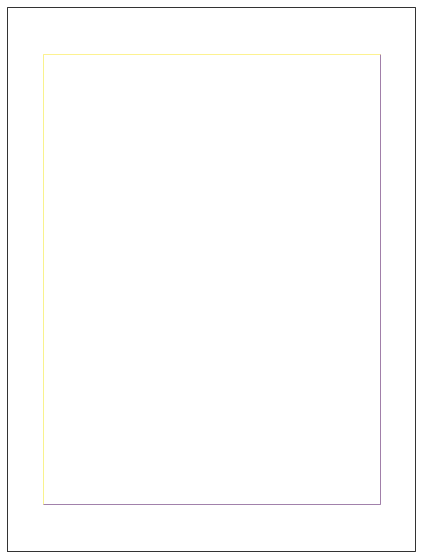

In [66]:
# Solve network and plot network insights
network.lopf(solver_name="gurobi", 
             formulation ="kirchhoff", 
             extra_functionality = my_f)
print_lopf_insights(network)


# print line loadings 
series_loading  = ((network.lines_t.p0.abs().mean().sort_index() / 
                    (network.lines.s_nom_opt*network.lines.s_max_pu)
                    .sort_index()).fillna(0.))


fig,ax = plt.subplots(figsize = (10,10),subplot_kw = {"projection": ccrs.PlateCarree()})

network.plot(ax=ax,
       bus_colors ="gray",
       branch_components = ["Line"],
       line_widths = network.lines.s_nom_opt/3e3,
       line_colors = series_loading,
       line_cmap=plt.cm.viridis,
       color_geomap = True,
       bus_sizes = 0,
       geomap = False)

ax.axis("on")



In [64]:
#### Create separate small model with additional pumped hydro storage units

# Build another grid with hydro storages
network_phes = network.copy()
add_storage_units(network_phes)

display(network_phes.storage_units)
display(network_phes.stores)
display(network_phes.buses)


attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,capital_cost,state_of_charge_initial,state_of_charge_set,cyclic_state_of_charge,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
PHES_1,bus_4_se,PQ,,150.0,True,0.0,inf,-1.0,1.0,0.0,...,0.0,0.0,NaN,False,1000.0,0.86,0.89,0.01,0.02,0.0


attribute,bus,type,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,e_cyclic,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,e_nom_opt
name,,,,,,,,,,,,,,,,,


,v_nom,control,x,y,type,carrier,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network,generator
bus_1_nw,220.0,Slack,8.0,52.0,,AC,1.0,0.0,inf,0,coal_1
bus_2_ne,220.0,PQ,11.0,52.0,,AC,1.0,0.0,inf,0,NaN
bus_3_sw,220.0,PQ,8.0,48.0,,AC,1.0,0.0,inf,0,NaN
bus_4_se,220.0,PQ,11.0,48.0,,AC,1.0,0.0,inf,0,NaN


INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi


DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-12-30 14:00:00', '2020-12-30 15:00:00',
               '2020-12-30 16:00:00', '2020-12-30 17:00:00',
               '2020-12-30 18:00:00', '2020-12-30 19:00:00',
               '2020-12-30 20:00:00', '2020-12-30 21:00:00',
               '2020-12-30 22:00:00', '2020-12-30 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x140164_copy
  Lower bound: 184248889.69904867
  Upper bound: 184248889.69904867
  Number of objectives: 1
  Number of constraints: 183961
  Number of variables: 140164
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 140164
  Number of nonzeros: 411720
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termina

(7.685, 11.315000000000001, 47.58, 52.42)

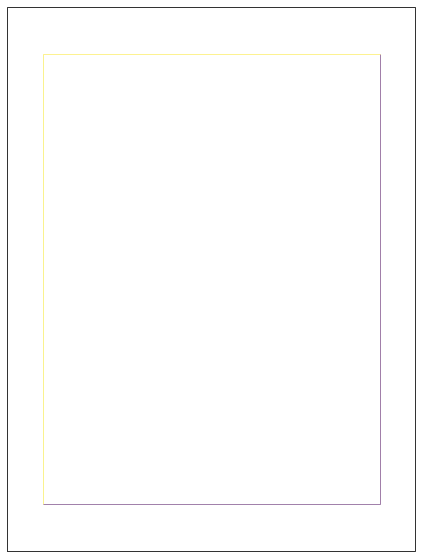

In [65]:
# Solve network_phes and plot network_phes insights
network_phes.lopf(solver_name="gurobi", 
             formulation ="kirchhoff", 
             extra_functionality = my_f)
print_lopf_insights(network_phes)

# print line loadings 
series_loading  = ((network_phes.lines_t.p0.abs().mean().sort_index() / 
                    (network_phes.lines.s_nom_opt*network_phes.lines.s_max_pu)
                    .sort_index()).fillna(0.))

fig,ax = plt.subplots(figsize = (10,10),subplot_kw = {"projection": ccrs.PlateCarree()})

network_phes.plot(ax=ax,
       bus_colors ="gray",
       branch_components = ["Line"],
       line_widths = network_phes.lines.s_nom_opt/3e3,
       line_colors = series_loading,
       line_cmap=plt.cm.viridis,
       color_geomap = True,
       bus_sizes = 0,
       geomap = False)

ax.axis("on")

In [69]:
#### Create separate small model with additional pumped hydro storage units

# Build another grid with hydro storages
network_bat = network_phes.copy()
add_BESS(network_bat)

display(network_bat.storage_units)
display(network_bat.links)
display(network_bat.stores)
display(network_bat.buses)

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,capital_cost,state_of_charge_initial,state_of_charge_set,cyclic_state_of_charge,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
PHES_1,bus_4_se,PQ,,150.0,True,0.0,inf,-1.0,1.0,0.0,...,0.0,0.0,NaN,False,1000.0,0.86,0.89,0.01,0.02,256.570297


attribute,bus0,bus1,type,efficiency,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,length,terrain_factor,p_nom_opt
Battery_1_dCH,bus_1_nw_BESS,bus_1_nw,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_1_CH,bus_1_nw,bus_1_nw_BESS,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_2_dCH,bus_2_ne_BESS,bus_2_ne,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_2_CH,bus_2_ne,bus_2_ne_BESS,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_3_dCH,bus_3_sw_BESS,bus_3_sw,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_3_CH,bus_3_sw,bus_3_sw_BESS,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_4_dCH,bus_4_se_BESS,bus_4_se,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Battery_4_CH,bus_4_se,bus_4_se_BESS,,0.96,150.0,True,0.0,inf,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


attribute,bus,type,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,e_cyclic,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,e_nom_opt
BESS_0,bus_1_nw_BESS,,200.0,False,0.0,inf,0.0,1.0,0.5,True,100.0,0.05,1.0,0.0,0.0,0.0,0.0
BESS_1,bus_2_ne_BESS,,200.0,False,0.0,inf,0.0,1.0,0.5,True,100.0,0.05,1.0,0.0,0.0,0.0,0.0
BESS_2,bus_3_sw_BESS,,200.0,False,0.0,inf,0.0,1.0,0.5,True,100.0,0.05,1.0,0.0,0.0,0.0,0.0
BESS_3,bus_4_se_BESS,,200.0,False,0.0,inf,0.0,1.0,0.5,True,100.0,0.05,1.0,0.0,0.0,0.0,0.0


,v_nom,control,x,y,type,carrier,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network,generator
bus_1_nw,220.0,Slack,8.0,52.0,,AC,1.0,0.0,inf,0,coal_1
bus_2_ne,220.0,PQ,11.0,52.0,,AC,1.0,0.0,inf,0,NaN
bus_3_sw,220.0,PQ,8.0,48.0,,AC,1.0,0.0,inf,0,NaN
bus_4_se,220.0,PQ,11.0,48.0,,AC,1.0,0.0,inf,0,NaN
bus_1_nw_BESS,1.0,PQ,8.0,52.0,,battery,1.0,0.0,inf,,NaN
bus_2_ne_BESS,1.0,PQ,11.0,52.0,,battery,1.0,0.0,inf,,NaN
bus_3_sw_BESS,1.0,PQ,8.0,48.0,,battery,1.0,0.0,inf,,NaN
bus_4_se_BESS,1.0,PQ,11.0,48.0,,battery,1.0,0.0,inf,,NaN


INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi


DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-12-30 14:00:00', '2020-12-30 15:00:00',
               '2020-12-30 16:00:00', '2020-12-30 17:00:00',
               '2020-12-30 18:00:00', '2020-12-30 19:00:00',
               '2020-12-30 20:00:00', '2020-12-30 21:00:00',
               '2020-12-30 22:00:00', '2020-12-30 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x280332_copy
  Lower bound: 180647809.92399108
  Upper bound: 180647809.92399108
  Number of objectives: 1
  Number of constraints: 394201
  Number of variables: 280332
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 280332
  Number of nonzeros: 902280
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termina

(7.685, 11.315000000000001, 47.58, 52.42)

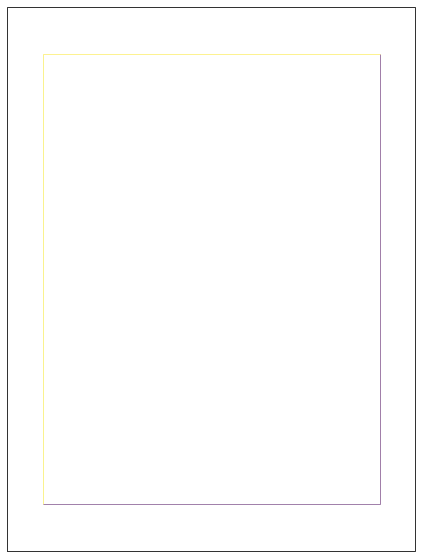

In [70]:
# Solve network_bat and plot network_bat insights
network_bat.lopf(solver_name="gurobi", 
             formulation ="kirchhoff", 
             extra_functionality = my_f)
print_lopf_insights(network_bat)

# print line loadings 
series_loading  = ((network_bat.lines_t.p0.abs().mean().sort_index() / 
                    (network_bat.lines.s_nom_opt*network_bat.lines.s_max_pu)
                    .sort_index()).fillna(0.))

fig,ax = plt.subplots(figsize = (10,10),subplot_kw = {"projection": ccrs.PlateCarree()})

network_bat.plot(ax=ax,
       bus_colors ="gray",
       branch_components = ["Line"],
       line_widths = network_bat.lines.s_nom_opt/3e3,
       line_colors = series_loading,
       line_cmap=plt.cm.viridis,
       color_geomap = True,
       bus_sizes = 0,
       geomap = False)

ax.axis("on")

In [77]:
print(network.loads_t.p_set)

name                  load_1_ne   load_2_sw   load_3_se
2020-01-01 00:00:00    5.245469  824.987020  893.027309
2020-01-01 01:00:00  493.204659   70.036152   63.725161
2020-01-01 02:00:00  105.847768  856.638597  731.079657
2020-01-01 03:00:00  380.841148  865.038899  795.611178
2020-01-01 04:00:00  210.354699  526.579315  231.490640
...                         ...         ...         ...
2020-12-30 19:00:00  365.729274  755.731084  163.936975
2020-12-30 20:00:00   83.673216  387.236023  365.898987
2020-12-30 21:00:00  132.404097  225.741149  651.840217
2020-12-30 22:00:00  377.126650  718.036945  723.847822
2020-12-30 23:00:00  936.319426  761.787677  955.511642

[8760 rows x 3 columns]
